## XGBoost Match Outcome Prediction

### Inputs
- All numeric features from dataset (team statistics, goals, positions, etc.)
- homeTeam_name (encoded)
- awayTeam_name (encoded)

### Target
- 0 = Loss (away team wins)
- 1 = Draw
- 2 = Win (home team wins)


In [9]:
%pip install pandas numpy scikit-learn matplotlib seaborn xgboost optuna plotly


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from __future__ import annotations

import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
)
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

import xgboost as xgb
import optuna
from optuna.samplers import TPESampler

# Env settings for matplotlib
os.environ.setdefault("MPLCONFIGDIR", str(Path.cwd() / ".mplconfig"))
Path(os.environ["MPLCONFIGDIR"]).mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120


## 2) Load the dataset

- Load all available features from ml_dataset.csv
- Clean team names and matchday
- Prepare for feature engineering


In [28]:
DATA_PATH = Path("..") / "cleared_data" / "ml_dataset.csv"

df_raw = pd.read_csv(DATA_PATH)

# Basic cleanup
df = df_raw.copy()

# Clean team names
for c in ["homeTeam_name", "awayTeam_name"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

# Drop rows with missing target
df = df.dropna(subset=["match_outcome"]).copy()
df["match_outcome"] = df["match_outcome"].astype(int)

# Ensure matchday is integer
if "matchday" in df.columns:
    df = df.dropna(subset=["matchday"]).copy()
    df["matchday"] = df["matchday"].astype(int)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
df.head()


Dataset shape: (1140, 86)
Columns: 86


,awayTeam_name,competition_name,homeTeam_name,matchday,score_fullTime_away,score_fullTime_home,score_halfTime_away,score_halfTime_home,match_outcome,home_points,...,goals_against_diff,points_diff,position_diff,home_advantage_metric,top_scorer_goals_diff,top3_goals_diff,scoring_depth_diff,num_scorers_diff,total_goals,goal_margin
0,Rayo Vallecano de Madrid,Primera Division,UD Almería,1,2.0,0.0,2.0,0.0,0,21,...,27,-31,-10,-13,3.0,4.0,-2.0,-1.0,2.0,-2.0
1,Valencia CF,Primera Division,Sevilla FC,1,2.0,1.0,0.0,0.0,0,41,...,1,-8,-4,8,3.0,-2.0,-24.0,-4.0,3.0,-1.0
2,Girona FC,Primera Division,Real Sociedad de Fútbol,1,1.0,1.0,0.0,1.0,1,60,...,-14,-21,-3,3,-15.0,-19.0,-19.0,-1.0,2.0,0.0
3,RCD Mallorca,Primera Division,UD Las Palmas,1,1.0,1.0,0.0,1.0,1,40,...,17,-8,-6,1,0.0,1.0,-6.0,-1.0,2.0,0.0
4,Real Madrid CF,Primera Division,Athletic Club,1,2.0,0.0,2.0,0.0,0,70,...,-1,-25,-3,-1,-16.0,-27.0,-61.0,-4.0,2.0,-2.0


## 3) Feature Engineering

- Separate numeric and categorical features
- Identify all available features from the dataset
- Map outcome labels


In [46]:
OUTCOME_LABELS = {0: "Loss", 1: "Draw", 2: "Win"}

# Sanity check
unexpected = sorted(set(df["match_outcome"]) - set(OUTCOME_LABELS))
if unexpected:
    raise ValueError(f"Unexpected match_outcome values: {unexpected}")

df["outcome_label"] = df["match_outcome"].map(OUTCOME_LABELS)

# Identify feature columns (exclude target and metadata)
exclude_cols = [
    "match_outcome", "outcome_label", 
    "homeTeam_name", "awayTeam_name",  # Will encode separately
    "competition_name",  # If exists, might want to exclude or encode
    "matchday",  # Used for splitting, not as feature
    # Exclude actual match scores - these cause data leakage!
    "score_fullTime_home", "score_fullTime_away",
    "score_halfTime_home", "score_halfTime_away",
    "total_goals", "goal_margin",  # Derived from scores
]

# Separate categorical and numeric features
categorical_cols = []
numeric_cols = []

for col in df.columns:
    if col in exclude_cols:
        continue
    if df[col].dtype == 'object':
        categorical_cols.append(col)
    elif df[col].dtype in ['int64', 'float64']:
        numeric_cols.append(col)

print(f"Categorical features: {len(categorical_cols)}")
print(f"Numeric features: {len(numeric_cols)}")
print(f"\nNumeric features: {numeric_cols[:10]}...")


Categorical features: 0
Numeric features: 75

Numeric features: ['home_points', 'home_won', 'home_draw', 'home_lost', 'home_goalsFor', 'home_goalsAgainst', 'home_goalDifference', 'home_position', 'home_team_id_match', 'home_home_wins']...


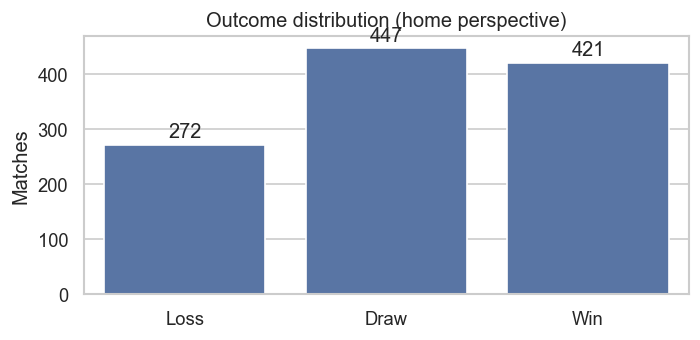


Class distribution:
outcome_label
Draw    447
Win     421
Loss    272
Name: count, dtype: int64

Class percentages:
outcome_label
Draw    0.392
Win     0.369
Loss    0.239
Name: proportion, dtype: float64


In [47]:
# Visualize outcome distribution
order = ["Loss", "Draw", "Win"]

plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df, x="outcome_label", order=order)
ax.set_title("Outcome distribution (home perspective)")
ax.set_xlabel("")
ax.set_ylabel("Matches")
for container in ax.containers:
    ax.bar_label(container, padding=2)
plt.tight_layout()
plt.show()

# Check class distribution
print("\nClass distribution:")
print(df["outcome_label"].value_counts())
print("\nClass percentages:")
print(df["outcome_label"].value_counts(normalize=True).round(3))


## 4) Train/test split (80%/20%)

- Time-aware split based on matchday
- Encode team names using LabelEncoder
- Prepare feature matrices
- Handle missing values with median imputation


In [48]:
matchdays = np.array(sorted(df["matchday"].unique()))
if len(matchdays) < 5:
    raise ValueError("Not enough unique matchdays for time-aware splitting.")

split_at = int(np.floor(0.8 * len(matchdays)))
train_days = set(matchdays[:split_at])
test_days = set(matchdays[split_at:])

train_df = df[df["matchday"].isin(train_days)].copy()
test_df = df[df["matchday"].isin(test_days)].copy()

# Prepare features
# XGBoost can handle categorical features natively, but we'll use label encoding for team names
# and keep numeric features as-is

feature_cols = numeric_cols.copy()

# Add encoded team names
le_home = LabelEncoder()
le_away = LabelEncoder()

train_df["homeTeam_encoded"] = le_home.fit_transform(train_df["homeTeam_name"])
train_df["awayTeam_encoded"] = le_away.fit_transform(train_df["awayTeam_name"])

test_df["homeTeam_encoded"] = le_home.transform(test_df["homeTeam_name"])
test_df["awayTeam_encoded"] = le_away.transform(test_df["awayTeam_name"])

feature_cols.extend(["homeTeam_encoded", "awayTeam_encoded"])

X_train = train_df[feature_cols].copy()
y_train = train_df["match_outcome"]

X_test = test_df[feature_cols].copy()
y_test = test_df["match_outcome"]

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Train/Test Split Summary:")
print(f"  Total matches: {len(df)}")
print(f"  Train matches: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Test matches: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
print(f"  Features: {len(feature_cols)}")
print(f"  Train matchdays: {len(train_days)} (range: {min(train_days)}-{max(train_days)})")
print(f"  Test matchdays: {len(test_days)} (range: {min(test_days)}-{max(test_days)})")
print(f"\nTrain class distribution:")
print(train_df["match_outcome"].value_counts().sort_index())
print(f"\nTest class distribution:")
print(test_df["match_outcome"].value_counts().sort_index())


Train/Test Split Summary:
  Total matches: 1140
  Train matches: 900 (78.9%)
  Test matches: 240 (21.1%)
  Features: 77
  Train matchdays: 30 (range: 1-30)
  Test matchdays: 8 (range: 31-38)

Train class distribution:
match_outcome
0    217
1    334
2    349
Name: count, dtype: int64

Test class distribution:
match_outcome
0     55
1    113
2     72
Name: count, dtype: int64


## 5) Time-aware cross-validation

- Create CV splits based on matchday to prevent data leakage
- Ensures training on past data, validating on future data


In [50]:
def make_matchday_time_cv_splits(df_subset: pd.DataFrame, n_splits: int = 5):
    """Create time-aware cross-validation splits based on matchday."""
    unique_days = np.array(sorted(df_subset["matchday"].unique()))
    if len(unique_days) < (n_splits + 1):
        n_splits = max(2, min(3, len(unique_days) - 1))
    
    day_splits = np.array_split(unique_days, n_splits + 1)
    
    splits = []
    matchday_arr = df_subset["matchday"].to_numpy()
    
    for i in range(1, len(day_splits)):
        train_days = np.concatenate(day_splits[:i])
        val_days = day_splits[i]
        
        train_idx = np.flatnonzero(np.isin(matchday_arr, train_days))
        val_idx = np.flatnonzero(np.isin(matchday_arr, val_days))
        
        if len(train_idx) == 0 or len(val_idx) == 0:
            continue
        splits.append((train_idx, val_idx))
    
    return splits

cv_splits = make_matchday_time_cv_splits(train_df, n_splits=5)
print(f"CV splits: {len(cv_splits)}")
print(f"Split sizes: {[(len(tr), len(va)) for tr, va in cv_splits]}")

# Diagnostic: Check class distribution in CV splits
print("\nClass distribution in CV splits:")
for i, (train_idx, val_idx) in enumerate(cv_splits):
    y_train_cv = y_train.iloc[train_idx]
    y_val_cv = y_train.iloc[val_idx]
    print(f"\nFold {i+1}:")
    print(f"  Train: {len(train_idx)} samples, classes: {dict(y_train_cv.value_counts())}")
    print(f"  Val:   {len(val_idx)} samples, classes: {dict(y_val_cv.value_counts())}")

# Check for data leakage - verify train and val indices don't overlap
print("\nChecking for data leakage:")
for i, (train_idx, val_idx) in enumerate(cv_splits):
    overlap = set(train_idx) & set(val_idx)
    if len(overlap) > 0:
        print(f"  WARNING: Fold {i+1} has {len(overlap)} overlapping indices!")
    else:
        print(f"  Fold {i+1}: No overlap ✓")


CV splits: 5
Split sizes: [(150, 150), (300, 150), (450, 150), (600, 150), (750, 150)]

Class distribution in CV splits:

Fold 1:
  Train: 150 samples, classes: {2: np.int64(72), 0: np.int64(43), 1: np.int64(35)}
  Val:   150 samples, classes: {2: np.int64(62), 1: np.int64(48), 0: np.int64(40)}

Fold 2:
  Train: 300 samples, classes: {2: np.int64(134), 0: np.int64(83), 1: np.int64(83)}
  Val:   150 samples, classes: {2: np.int64(73), 1: np.int64(42), 0: np.int64(35)}

Fold 3:
  Train: 450 samples, classes: {2: np.int64(207), 1: np.int64(125), 0: np.int64(118)}
  Val:   150 samples, classes: {2: np.int64(60), 1: np.int64(50), 0: np.int64(40)}

Fold 4:
  Train: 600 samples, classes: {2: np.int64(267), 1: np.int64(175), 0: np.int64(158)}
  Val:   150 samples, classes: {1: np.int64(82), 2: np.int64(38), 0: np.int64(30)}

Fold 5:
  Train: 750 samples, classes: {2: np.int64(305), 1: np.int64(257), 0: np.int64(188)}
  Val:   150 samples, classes: {1: np.int64(77), 2: np.int64(44), 0: np.int64

## 6) Hyperparameter tuning

- Use Optuna for automated hyperparameter optimization
- Tune: max_depth, learning_rate, n_estimators, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda
- Optimize for macro F1 score using time-aware CV
- **Note**: If F1 scores are suspiciously high (1.0), check the debug output below


In [51]:
def objective(trial):
    """Optuna objective function for hyperparameter tuning."""
    
    # Calculate class weights to handle imbalance
    from sklearn.utils.class_weight import compute_sample_weight
    class_weights = compute_sample_weight('balanced', y_train)
    
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'booster': 'gbtree',
        'tree_method': 'hist',
        'random_state': RANDOM_STATE,
        'verbosity': 0,
        
        # Hyperparameters to tune
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        # Use small positive lower bound for log scale
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    # Cross-validation
    cv_scores = []
    for fold, (train_idx, val_idx) in enumerate(cv_splits):
        # Use .iloc with proper indexing
        X_train_cv = X_train.iloc[train_idx].copy()
        y_train_cv = y_train.iloc[train_idx].copy()
        X_val_cv = X_train.iloc[val_idx].copy()
        y_val_cv = y_train.iloc[val_idx].copy()
        
        # Check if validation set has all classes
        unique_classes = set(y_val_cv.unique())
        if len(unique_classes) < 3:
            # Skip this fold if not all classes present
            continue
        
        # Check minimum size - require at least 10 validation samples
        if len(X_val_cv) < 10 or len(X_train_cv) < 20:
            continue
        
        # Get sample weights for this fold
        sample_weights_cv = class_weights[train_idx]
        
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_cv, y_train_cv,
            sample_weight=sample_weights_cv,
            eval_set=[(X_val_cv, y_val_cv)],
            verbose=False
        )
        
        y_pred_cv = model.predict(X_val_cv)
        f1 = f1_score(y_val_cv, y_pred_cv, average='macro', zero_division=0)
        
        # Debug: Print details for first trial only
        if trial.number == 0:
            acc = accuracy_score(y_val_cv, y_pred_cv)
            f1_per_class = f1_score(y_val_cv, y_pred_cv, average=None, zero_division=0)
            print(f"\nTrial {trial.number}, Fold {fold+1}:")
            print(f"  Train: {len(X_train_cv)} samples, Val: {len(X_val_cv)} samples")
            print(f"  Val true: {dict(y_val_cv.value_counts().sort_index())}")
            print(f"  Val pred: {dict(pd.Series(y_pred_cv).value_counts().sort_index())}")
            print(f"  Accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"  F1 per class [Loss, Draw, Win]: {[f'{x:.4f}' for x in f1_per_class]}")
        
        cv_scores.append(f1)
    
    # Return mean, or a low score if no valid folds
    if len(cv_scores) == 0:
        if trial.number == 0:
            print("WARNING: No valid CV folds found!")
        return 0.0
    
    mean_f1 = np.mean(cv_scores)
    if trial.number == 0:
        print(f"\nTrial {trial.number} summary: {len(cv_scores)} valid folds, mean F1: {mean_f1:.4f}")
        print(f"  Individual fold F1s: {[f'{f:.4f}' for f in cv_scores]}")
    
    return mean_f1

# Create study and optimize
print("Starting hyperparameter optimization with Optuna...")
print("This may take several minutes...")

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE)
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nBest trial:")
print(f"  Value (CV F1-macro): {study.best_value:.4f}")
print(f"  Params: {study.best_params}")


[I 2026-01-21 22:17:23,693] A new study created in memory with name: no-name-ffa423bc-c134-4517-9147-0ff0080ca3d0


Starting hyperparameter optimization with Optuna...
This may take several minutes...


  0%|          | 0/50 [00:00<?, ?it/s]


Trial 0, Fold 1:
  Train: 150 samples, Val: 150 samples
  Val true: {0: np.int64(40), 1: np.int64(48), 2: np.int64(62)}
  Val pred: {0: np.int64(48), 1: np.int64(27), 2: np.int64(75)}
  Accuracy: 0.4667, F1-macro: 0.4309
  F1 per class [Loss, Draw, Win]: ['0.3864', '0.2933', '0.6131']

Trial 0, Fold 2:
  Train: 300 samples, Val: 150 samples
  Val true: {0: np.int64(35), 1: np.int64(42), 2: np.int64(73)}
  Val pred: {0: np.int64(49), 1: np.int64(40), 2: np.int64(61)}
  Accuracy: 0.4800, F1-macro: 0.4525
  F1 per class [Loss, Draw, Win]: ['0.4286', '0.3171', '0.6119']

Trial 0, Fold 3:
  Train: 450 samples, Val: 150 samples
  Val true: {0: np.int64(40), 1: np.int64(50), 2: np.int64(60)}
  Val pred: {0: np.int64(49), 1: np.int64(33), 2: np.int64(68)}
  Accuracy: 0.4733, F1-macro: 0.4550
  F1 per class [Loss, Draw, Win]: ['0.4494', '0.3373', '0.5781']

Trial 0, Fold 4:
  Train: 600 samples, Val: 150 samples
  Val true: {0: np.int64(30), 1: np.int64(82), 2: np.int64(38)}
  Val pred: {0: np

Best trial: 0. Best value: 0.402165:   2%|▏         | 1/50 [00:02<02:09,  2.64s/it]


Trial 0, Fold 5:
  Train: 750 samples, Val: 150 samples
  Val true: {0: np.int64(29), 1: np.int64(77), 2: np.int64(44)}
  Val pred: {0: np.int64(44), 1: np.int64(45), 2: np.int64(61)}
  Accuracy: 0.3600, F1-macro: 0.3439
  F1 per class [Loss, Draw, Win]: ['0.2192', '0.3934', '0.4190']

Trial 0 summary: 5 valid folds, mean F1: 0.4022
  Individual fold F1s: ['0.4309', '0.4525', '0.4550', '0.3285', '0.3439']
[I 2026-01-21 22:17:26,329] Trial 0 finished with value: 0.40216526208317527 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'n_estimators': 380, 'min_child_weight': 6, 'gamma': 0.7800932022121826, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.40216526208317527.


Best trial: 1. Best value: 0.422062:   4%|▍         | 2/50 [00:07<03:14,  4.06s/it]

[I 2026-01-21 22:17:31,387] Trial 1 finished with value: 0.4220620361367346 and parameters: {'max_depth': 8, 'learning_rate': 0.010725209743171996, 'n_estimators': 487, 'min_child_weight': 9, 'gamma': 1.0616955533913808, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.4220620361367346.


Best trial: 2. Best value: 0.424297:   6%|▌         | 3/50 [00:10<02:38,  3.37s/it]

[I 2026-01-21 22:17:33,939] Trial 2 finished with value: 0.42429651139716534 and parameters: {'max_depth': 6, 'learning_rate': 0.02692655251486473, 'n_estimators': 325, 'min_child_weight': 2, 'gamma': 1.4607232426760908, 'subsample': 0.7465447373174767, 'colsample_bytree': 0.7824279936868144, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062696005991e-07}. Best is trial 2 with value: 0.42429651139716534.


Best trial: 2. Best value: 0.424297:   8%|▊         | 4/50 [00:10<01:46,  2.32s/it]

[I 2026-01-21 22:17:34,650] Trial 3 finished with value: 0.405619655247537 and parameters: {'max_depth': 7, 'learning_rate': 0.07500118950416987, 'n_estimators': 70, 'min_child_weight': 7, 'gamma': 0.8526206184364576, 'subsample': 0.6260206371941118, 'colsample_bytree': 0.9795542149013333, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 2 with value: 0.42429651139716534.


Best trial: 4. Best value: 0.426486:  10%|█         | 5/50 [00:14<02:00,  2.67s/it]

[I 2026-01-21 22:17:37,935] Trial 4 finished with value: 0.4264861519301295 and parameters: {'max_depth': 5, 'learning_rate': 0.013940346079873234, 'n_estimators': 358, 'min_child_weight': 5, 'gamma': 0.6101911742238941, 'subsample': 0.798070764044508, 'colsample_bytree': 0.6137554084460873, 'reg_alpha': 1.527156759251193, 'reg_lambda': 2.133142332373004e-06}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 4. Best value: 0.426486:  12%|█▏        | 6/50 [00:16<01:46,  2.43s/it]

[I 2026-01-21 22:17:39,899] Trial 5 finished with value: 0.4069675844576591 and parameters: {'max_depth': 8, 'learning_rate': 0.028869220380495747, 'n_estimators': 284, 'min_child_weight': 6, 'gamma': 0.9242722776276352, 'subsample': 0.9878338511058234, 'colsample_bytree': 0.9100531293444458, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 4. Best value: 0.426486:  14%|█▍        | 7/50 [00:17<01:29,  2.09s/it]

[I 2026-01-21 22:17:41,285] Trial 6 finished with value: 0.41193289965708557 and parameters: {'max_depth': 7, 'learning_rate': 0.22999586428143728, 'n_estimators': 89, 'min_child_weight': 2, 'gamma': 0.22613644455269033, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'reg_alpha': 2.7678419414850017e-06, 'reg_lambda': 0.28749982347407854}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 4. Best value: 0.426486:  16%|█▌        | 8/50 [00:19<01:25,  2.04s/it]

[I 2026-01-21 22:17:43,218] Trial 7 finished with value: 0.4138380632868265 and parameters: {'max_depth': 5, 'learning_rate': 0.026000059117302653, 'n_estimators': 294, 'min_child_weight': 2, 'gamma': 4.010984903770199, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'reg_alpha': 0.08916674715636537, 'reg_lambda': 6.143857495033091e-07}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 4. Best value: 0.426486:  18%|█▊        | 9/50 [00:21<01:21,  2.00s/it]

[I 2026-01-21 22:17:45,118] Trial 8 finished with value: 0.42407710164795154 and parameters: {'max_depth': 3, 'learning_rate': 0.1601531217136121, 'n_estimators': 368, 'min_child_weight': 8, 'gamma': 3.8563517334297286, 'subsample': 0.6296178606936361, 'colsample_bytree': 0.7433862914177091, 'reg_alpha': 1.1036250149900698e-07, 'reg_lambda': 0.5860448217200517}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 4. Best value: 0.426486:  20%|██        | 10/50 [00:22<01:06,  1.66s/it]

[I 2026-01-21 22:17:46,018] Trial 9 finished with value: 0.4148851283480569 and parameters: {'max_depth': 7, 'learning_rate': 0.030816017044468066, 'n_estimators': 78, 'min_child_weight': 4, 'gamma': 1.6259166101337352, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 4. Best value: 0.426486:  22%|██▏       | 11/50 [00:23<01:03,  1.63s/it]

[I 2026-01-21 22:17:47,602] Trial 10 finished with value: 0.4100081995193395 and parameters: {'max_depth': 10, 'learning_rate': 0.010206070557577008, 'n_estimators': 188, 'min_child_weight': 4, 'gamma': 2.680942943488798, 'subsample': 0.8429521169792498, 'colsample_bytree': 0.6060507263653538, 'reg_alpha': 0.003327054963436224, 'reg_lambda': 2.6701270073566428e-08}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 4. Best value: 0.426486:  24%|██▍       | 12/50 [00:26<01:13,  1.94s/it]

[I 2026-01-21 22:17:50,249] Trial 11 finished with value: 0.4229253237889086 and parameters: {'max_depth': 5, 'learning_rate': 0.01784561132579875, 'n_estimators': 399, 'min_child_weight': 1, 'gamma': 2.1717813587820567, 'subsample': 0.7623935852452096, 'colsample_bytree': 0.6960266332554614, 'reg_alpha': 0.012098055308424125, 'reg_lambda': 2.9195814354420653e-06}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 4. Best value: 0.426486:  26%|██▌       | 13/50 [00:28<01:07,  1.82s/it]

[I 2026-01-21 22:17:51,780] Trial 12 finished with value: 0.41973539558353934 and parameters: {'max_depth': 3, 'learning_rate': 0.058261802534285465, 'n_estimators': 201, 'min_child_weight': 4, 'gamma': 3.033425041274395, 'subsample': 0.8206301390946336, 'colsample_bytree': 0.8307285498632252, 'reg_alpha': 0.00038953524947340465, 'reg_lambda': 4.792928537079951e-06}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 4. Best value: 0.426486:  28%|██▊       | 14/50 [00:32<01:31,  2.54s/it]

[I 2026-01-21 22:17:55,995] Trial 13 finished with value: 0.42005484473929455 and parameters: {'max_depth': 4, 'learning_rate': 0.017403489604395823, 'n_estimators': 469, 'min_child_weight': 10, 'gamma': 0.018276327630166067, 'subsample': 0.7371303839678691, 'colsample_bytree': 0.7799284400583516, 'reg_alpha': 0.05331495630774895, 'reg_lambda': 2.166349874652891e-08}. Best is trial 4 with value: 0.4264861519301295.


Best trial: 14. Best value: 0.430041:  30%|███       | 15/50 [00:34<01:23,  2.39s/it]

[I 2026-01-21 22:17:58,039] Trial 14 finished with value: 0.4300408164654388 and parameters: {'max_depth': 6, 'learning_rate': 0.039052350587398546, 'n_estimators': 329, 'min_child_weight': 3, 'gamma': 1.8368944361000805, 'subsample': 0.9006453699263156, 'colsample_bytree': 0.6770160505196321, 'reg_alpha': 0.0003278583999966373, 'reg_lambda': 2.9428601693167397e-05}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  32%|███▏      | 16/50 [00:35<01:11,  2.09s/it]

[I 2026-01-21 22:17:59,432] Trial 15 finished with value: 0.4224219788281637 and parameters: {'max_depth': 6, 'learning_rate': 0.09495434662127893, 'n_estimators': 230, 'min_child_weight': 5, 'gamma': 1.9676507617218981, 'subsample': 0.9170342443019279, 'colsample_bytree': 0.6690672880395834, 'reg_alpha': 3.029405009892626e-05, 'reg_lambda': 5.046729300747346e-05}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  34%|███▍      | 17/50 [00:38<01:11,  2.18s/it]

[I 2026-01-21 22:18:01,813] Trial 16 finished with value: 0.39880231446385156 and parameters: {'max_depth': 4, 'learning_rate': 0.04428335050197766, 'n_estimators': 428, 'min_child_weight': 3, 'gamma': 3.30299622914229, 'subsample': 0.8976471815878584, 'colsample_bytree': 0.7134275099761584, 'reg_alpha': 1.7578071939504844e-08, 'reg_lambda': 0.00997288368341444}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  36%|███▌      | 18/50 [00:40<01:13,  2.29s/it]

[I 2026-01-21 22:18:04,354] Trial 17 finished with value: 0.3974931783911758 and parameters: {'max_depth': 9, 'learning_rate': 0.015016714709687134, 'n_estimators': 340, 'min_child_weight': 5, 'gamma': 2.4374244188388015, 'subsample': 0.9640316852471267, 'colsample_bytree': 0.6467436381167784, 'reg_alpha': 0.0011990113267919763, 'reg_lambda': 2.4270364125444704e-05}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  38%|███▊      | 19/50 [00:41<01:01,  2.00s/it]

[I 2026-01-21 22:18:05,680] Trial 18 finished with value: 0.42592917759712573 and parameters: {'max_depth': 4, 'learning_rate': 0.0969193339743378, 'n_estimators': 142, 'min_child_weight': 7, 'gamma': 0.4403528087838049, 'subsample': 0.8516308753538024, 'colsample_bytree': 0.602938566130612, 'reg_alpha': 4.432175694746551e-05, 'reg_lambda': 1.7100817176988384e-07}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  40%|████      | 20/50 [00:43<00:59,  1.98s/it]

[I 2026-01-21 22:18:07,610] Trial 19 finished with value: 0.4228465690348136 and parameters: {'max_depth': 6, 'learning_rate': 0.04302553031342478, 'n_estimators': 246, 'min_child_weight': 3, 'gamma': 1.514278238756251, 'subsample': 0.7785288033800144, 'colsample_bytree': 0.6432548089129733, 'reg_alpha': 3.35918377898784e-07, 'reg_lambda': 1.3321510710971602e-05}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  42%|████▏     | 21/50 [00:46<01:01,  2.13s/it]

[I 2026-01-21 22:18:10,097] Trial 20 finished with value: 0.3713395511330487 and parameters: {'max_depth': 8, 'learning_rate': 0.014089446774882169, 'n_estimators': 433, 'min_child_weight': 1, 'gamma': 4.819612188009003, 'subsample': 0.9354348266823662, 'colsample_bytree': 0.7228239440288675, 'reg_alpha': 0.00012069538204604005, 'reg_lambda': 8.802075014264656}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  44%|████▍     | 22/50 [00:47<00:52,  1.89s/it]

[I 2026-01-21 22:18:11,417] Trial 21 finished with value: 0.42123152655926666 and parameters: {'max_depth': 4, 'learning_rate': 0.12053969073410709, 'n_estimators': 142, 'min_child_weight': 7, 'gamma': 0.4209396007339814, 'subsample': 0.845944625342571, 'colsample_bytree': 0.6012392809281897, 'reg_alpha': 2.7217278948374996e-05, 'reg_lambda': 1.7243586725068379e-07}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  46%|████▌     | 23/50 [00:50<00:56,  2.09s/it]

[I 2026-01-21 22:18:13,985] Trial 22 finished with value: 0.4063638620964718 and parameters: {'max_depth': 5, 'learning_rate': 0.06657596582821122, 'n_estimators': 326, 'min_child_weight': 7, 'gamma': 0.5442247022846911, 'subsample': 0.8644975768387129, 'colsample_bytree': 0.6690446252870086, 'reg_alpha': 3.6286155169364464e-06, 'reg_lambda': 1.547086136497956e-07}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  48%|████▊     | 24/50 [00:51<00:46,  1.79s/it]

[I 2026-01-21 22:18:15,067] Trial 23 finished with value: 0.42087355328584086 and parameters: {'max_depth': 4, 'learning_rate': 0.12692260357064344, 'n_estimators': 134, 'min_child_weight': 8, 'gamma': 1.3495261551736304, 'subsample': 0.8048612474594103, 'colsample_bytree': 0.6390568719819117, 'reg_alpha': 0.005246499315516862, 'reg_lambda': 1.5544977737472501e-06}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  50%|█████     | 25/50 [00:53<00:46,  1.87s/it]

[I 2026-01-21 22:18:17,118] Trial 24 finished with value: 0.4203593273122994 and parameters: {'max_depth': 3, 'learning_rate': 0.04087971200804147, 'n_estimators': 258, 'min_child_weight': 6, 'gamma': 0.4644293692657188, 'subsample': 0.865845247785944, 'colsample_bytree': 0.6040687099968606, 'reg_alpha': 0.00018156464559232805, 'reg_lambda': 1.0010045097336228e-07}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  52%|█████▏    | 26/50 [00:55<00:43,  1.83s/it]

[I 2026-01-21 22:18:18,848] Trial 25 finished with value: 0.42966163151795095 and parameters: {'max_depth': 6, 'learning_rate': 0.18812091625438832, 'n_estimators': 305, 'min_child_weight': 5, 'gamma': 1.9796372934003783, 'subsample': 0.7912108321984976, 'colsample_bytree': 0.6909255010328326, 'reg_alpha': 3.7330168354077543e-07, 'reg_lambda': 0.0001402816609320531}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  54%|█████▍    | 27/50 [00:56<00:41,  1.80s/it]

[I 2026-01-21 22:18:20,581] Trial 26 finished with value: 0.4243066559380246 and parameters: {'max_depth': 6, 'learning_rate': 0.16459309373110598, 'n_estimators': 301, 'min_child_weight': 3, 'gamma': 1.9748447160353635, 'subsample': 0.791984210042887, 'colsample_bytree': 0.7039471252682733, 'reg_alpha': 1.6902749588425184e-08, 'reg_lambda': 0.0002557179979797331}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  56%|█████▌    | 28/50 [00:59<00:42,  1.94s/it]

[I 2026-01-21 22:18:22,855] Trial 27 finished with value: 0.4215358965130395 and parameters: {'max_depth': 7, 'learning_rate': 0.021363563800011903, 'n_estimators': 354, 'min_child_weight': 5, 'gamma': 2.658626753750815, 'subsample': 0.719476825695416, 'colsample_bytree': 0.6839651465479349, 'reg_alpha': 2.1032906735141402e-07, 'reg_lambda': 0.003058026410579358}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 14. Best value: 0.430041:  58%|█████▊    | 29/50 [01:01<00:45,  2.19s/it]

[I 2026-01-21 22:18:25,624] Trial 28 finished with value: 0.42032956344602423 and parameters: {'max_depth': 5, 'learning_rate': 0.035663921595829776, 'n_estimators': 407, 'min_child_weight': 4, 'gamma': 1.8432034306258773, 'subsample': 0.7058868799218717, 'colsample_bytree': 0.7343941393462629, 'reg_alpha': 9.805400680393852e-07, 'reg_lambda': 5.5963701950015705e-05}. Best is trial 14 with value: 0.4300408164654388.


Best trial: 29. Best value: 0.433056:  60%|██████    | 30/50 [01:04<00:43,  2.19s/it]

[I 2026-01-21 22:18:27,827] Trial 29 finished with value: 0.4330558802824493 and parameters: {'max_depth': 5, 'learning_rate': 0.28133465507507244, 'n_estimators': 394, 'min_child_weight': 6, 'gamma': 1.1344953292369486, 'subsample': 0.8190914646842982, 'colsample_bytree': 0.6370358392123134, 'reg_alpha': 0.361864605016622, 'reg_lambda': 0.009771458666979243}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  62%|██████▏   | 31/50 [01:06<00:41,  2.19s/it]

[I 2026-01-21 22:18:30,021] Trial 30 finished with value: 0.4298068928301813 and parameters: {'max_depth': 6, 'learning_rate': 0.28886734997334046, 'n_estimators': 395, 'min_child_weight': 6, 'gamma': 1.1310726740559005, 'subsample': 0.8206375789034319, 'colsample_bytree': 0.8208660874633481, 'reg_alpha': 0.3390002298564678, 'reg_lambda': 0.020170396756838262}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  64%|██████▍   | 32/50 [01:08<00:41,  2.31s/it]

[I 2026-01-21 22:18:32,610] Trial 31 finished with value: 0.4130596097278403 and parameters: {'max_depth': 6, 'learning_rate': 0.29081602837775133, 'n_estimators': 452, 'min_child_weight': 6, 'gamma': 1.2157361756256277, 'subsample': 0.8236675384887115, 'colsample_bytree': 0.823008048869822, 'reg_alpha': 0.340378550586204, 'reg_lambda': 0.03148130899127172}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  66%|██████▌   | 33/50 [01:11<00:40,  2.36s/it]

[I 2026-01-21 22:18:35,084] Trial 32 finished with value: 0.41080191545633493 and parameters: {'max_depth': 6, 'learning_rate': 0.20848092502014556, 'n_estimators': 393, 'min_child_weight': 8, 'gamma': 1.1504811872723661, 'subsample': 0.6876417350588805, 'colsample_bytree': 0.8789464694806907, 'reg_alpha': 0.02485460986099195, 'reg_lambda': 0.0011628677281175308}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  68%|██████▊   | 34/50 [01:14<00:40,  2.51s/it]

[I 2026-01-21 22:18:37,952] Trial 33 finished with value: 0.384107888105829 and parameters: {'max_depth': 8, 'learning_rate': 0.2966177418521786, 'n_estimators': 492, 'min_child_weight': 6, 'gamma': 1.6591090683785532, 'subsample': 0.7641425526260082, 'colsample_bytree': 0.7763908307060701, 'reg_alpha': 9.765361283265431, 'reg_lambda': 0.017256245964807012}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  70%|███████   | 35/50 [01:16<00:34,  2.31s/it]

[I 2026-01-21 22:18:39,803] Trial 34 finished with value: 0.4169845675312619 and parameters: {'max_depth': 7, 'learning_rate': 0.1973104816858718, 'n_estimators': 308, 'min_child_weight': 5, 'gamma': 2.21871041544615, 'subsample': 0.8853763544456064, 'colsample_bytree': 0.8110947654811994, 'reg_alpha': 0.3752035840031359, 'reg_lambda': 0.0040499905037756}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  72%|███████▏  | 36/50 [01:18<00:33,  2.36s/it]

[I 2026-01-21 22:18:42,271] Trial 35 finished with value: 0.4242145610459861 and parameters: {'max_depth': 6, 'learning_rate': 0.17826032092678287, 'n_estimators': 373, 'min_child_weight': 6, 'gamma': 1.0615276848206647, 'subsample': 0.8230506937290182, 'colsample_bytree': 0.8970730169421429, 'reg_alpha': 0.0006214279945959046, 'reg_lambda': 0.072037260379585}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  74%|███████▍  | 37/50 [01:20<00:29,  2.27s/it]

[I 2026-01-21 22:18:44,325] Trial 36 finished with value: 0.4260672224038635 and parameters: {'max_depth': 5, 'learning_rate': 0.2538067452450863, 'n_estimators': 319, 'min_child_weight': 4, 'gamma': 0.8517981191351941, 'subsample': 0.9122050954694163, 'colsample_bytree': 0.9414705414003753, 'reg_alpha': 0.15112933070646004, 'reg_lambda': 0.0007217743079925941}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  76%|███████▌  | 38/50 [01:22<00:25,  2.10s/it]

[I 2026-01-21 22:18:46,035] Trial 37 finished with value: 0.4169930804068085 and parameters: {'max_depth': 7, 'learning_rate': 0.1497725625007251, 'n_estimators': 270, 'min_child_weight': 7, 'gamma': 1.3459989663422625, 'subsample': 0.940897343386504, 'colsample_bytree': 0.7583548252686989, 'reg_alpha': 9.608763473954745e-06, 'reg_lambda': 0.007475439539263022}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  78%|███████▊  | 39/50 [01:25<00:24,  2.27s/it]

[I 2026-01-21 22:18:48,694] Trial 38 finished with value: 0.4271588028649814 and parameters: {'max_depth': 8, 'learning_rate': 0.24151049928432933, 'n_estimators': 419, 'min_child_weight': 2, 'gamma': 1.8607843323450917, 'subsample': 0.7648755785929602, 'colsample_bytree': 0.6565845121859574, 'reg_alpha': 0.002761757292097811, 'reg_lambda': 0.06047500512402648}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  80%|████████  | 40/50 [01:27<00:22,  2.22s/it]

[I 2026-01-21 22:18:50,798] Trial 39 finished with value: 0.412561586536248 and parameters: {'max_depth': 5, 'learning_rate': 0.08846748582588364, 'n_estimators': 343, 'min_child_weight': 3, 'gamma': 2.3223786738341765, 'subsample': 0.802470535634102, 'colsample_bytree': 0.6348961360606611, 'reg_alpha': 2.3417977241122587, 'reg_lambda': 0.0012910336195255051}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 29. Best value: 0.433056:  82%|████████▏ | 41/50 [01:29<00:20,  2.30s/it]

[I 2026-01-21 22:18:53,281] Trial 40 finished with value: 0.425857824061343 and parameters: {'max_depth': 6, 'learning_rate': 0.13048917489210726, 'n_estimators': 381, 'min_child_weight': 6, 'gamma': 0.7953551627550861, 'subsample': 0.9909999188917467, 'colsample_bytree': 0.8577104134670709, 'reg_alpha': 0.011918981812918967, 'reg_lambda': 0.00013686580690875846}. Best is trial 29 with value: 0.4330558802824493.


Best trial: 41. Best value: 0.43343:  84%|████████▍ | 42/50 [01:32<00:18,  2.37s/it] 

[I 2026-01-21 22:18:55,817] Trial 41 finished with value: 0.43342981862291585 and parameters: {'max_depth': 9, 'learning_rate': 0.2374339233194889, 'n_estimators': 427, 'min_child_weight': 2, 'gamma': 1.816337833887083, 'subsample': 0.7537583024476066, 'colsample_bytree': 0.6571962288312344, 'reg_alpha': 0.0017615896503871884, 'reg_lambda': 0.12945336156083645}. Best is trial 41 with value: 0.43342981862291585.


Best trial: 41. Best value: 0.43343:  86%|████████▌ | 43/50 [01:34<00:17,  2.51s/it]

[I 2026-01-21 22:18:58,638] Trial 42 finished with value: 0.42132123880308614 and parameters: {'max_depth': 10, 'learning_rate': 0.2623228368705245, 'n_estimators': 443, 'min_child_weight': 2, 'gamma': 1.6844305832136004, 'subsample': 0.7491473553823426, 'colsample_bytree': 0.6865918446412898, 'reg_alpha': 0.0011535358278474434, 'reg_lambda': 2.817978774471081}. Best is trial 41 with value: 0.43342981862291585.


Best trial: 41. Best value: 0.43343:  88%|████████▊ | 44/50 [01:37<00:15,  2.61s/it]

[I 2026-01-21 22:19:01,478] Trial 43 finished with value: 0.41935838521288504 and parameters: {'max_depth': 9, 'learning_rate': 0.20342009446638346, 'n_estimators': 467, 'min_child_weight': 1, 'gamma': 2.785555546735921, 'subsample': 0.7865831411352276, 'colsample_bytree': 0.6256964684250322, 'reg_alpha': 0.871201724697018, 'reg_lambda': 0.19343957581580545}. Best is trial 41 with value: 0.43342981862291585.


Best trial: 41. Best value: 0.43343:  90%|█████████ | 45/50 [01:40<00:12,  2.56s/it]

[I 2026-01-21 22:19:03,938] Trial 44 finished with value: 0.42514327745383307 and parameters: {'max_depth': 7, 'learning_rate': 0.22950674556407416, 'n_estimators': 383, 'min_child_weight': 3, 'gamma': 1.3978597179232888, 'subsample': 0.8180376589833672, 'colsample_bytree': 0.6633985735280619, 'reg_alpha': 0.04229172880216516, 'reg_lambda': 0.6724839103781736}. Best is trial 41 with value: 0.43342981862291585.


Best trial: 41. Best value: 0.43343:  92%|█████████▏| 46/50 [01:42<00:10,  2.52s/it]

[I 2026-01-21 22:19:06,370] Trial 45 finished with value: 0.43255312643043614 and parameters: {'max_depth': 6, 'learning_rate': 0.28196467588578855, 'n_estimators': 410, 'min_child_weight': 9, 'gamma': 2.1516640466020345, 'subsample': 0.6628244362129212, 'colsample_bytree': 0.8001748664782948, 'reg_alpha': 0.00010968432703043393, 'reg_lambda': 0.09351540288757755}. Best is trial 41 with value: 0.43342981862291585.


Best trial: 41. Best value: 0.43343:  94%|█████████▍| 47/50 [01:45<00:08,  2.74s/it]

[I 2026-01-21 22:19:09,617] Trial 46 finished with value: 0.41675527123889494 and parameters: {'max_depth': 9, 'learning_rate': 0.29550084654435294, 'n_estimators': 407, 'min_child_weight': 9, 'gamma': 1.0773298423503552, 'subsample': 0.6561280539283744, 'colsample_bytree': 0.8374821921261961, 'reg_alpha': 8.694223612984374e-05, 'reg_lambda': 0.0819562323546547}. Best is trial 41 with value: 0.43342981862291585.


Best trial: 41. Best value: 0.43343:  96%|█████████▌| 48/50 [01:48<00:05,  2.82s/it]

[I 2026-01-21 22:19:12,611] Trial 47 finished with value: 0.43026277666460533 and parameters: {'max_depth': 5, 'learning_rate': 0.05540613538363601, 'n_estimators': 475, 'min_child_weight': 10, 'gamma': 2.1487657653104955, 'subsample': 0.6043534195518357, 'colsample_bytree': 0.8005537899955254, 'reg_alpha': 1.4328834761127552e-05, 'reg_lambda': 1.5586327259607744}. Best is trial 41 with value: 0.43342981862291585.


Best trial: 41. Best value: 0.43343:  98%|█████████▊| 49/50 [01:51<00:02,  2.82s/it]

[I 2026-01-21 22:19:15,431] Trial 48 finished with value: 0.41434096142355487 and parameters: {'max_depth': 5, 'learning_rate': 0.0512392339884052, 'n_estimators': 474, 'min_child_weight': 10, 'gamma': 2.9736098751235116, 'subsample': 0.6475151557810543, 'colsample_bytree': 0.7626025923561836, 'reg_alpha': 1.1940992797077495e-05, 'reg_lambda': 1.9603288427557448}. Best is trial 41 with value: 0.43342981862291585.


Best trial: 41. Best value: 0.43343: 100%|██████████| 50/50 [01:54<00:00,  2.29s/it]

[I 2026-01-21 22:19:18,429] Trial 49 finished with value: 0.4171025088982022 and parameters: {'max_depth': 5, 'learning_rate': 0.023796416683210773, 'n_estimators': 497, 'min_child_weight': 9, 'gamma': 3.381709441503445, 'subsample': 0.6172835670778205, 'colsample_bytree': 0.7950361473622027, 'reg_alpha': 1.3030715281974513e-06, 'reg_lambda': 0.47360142354034857}. Best is trial 41 with value: 0.43342981862291585.

Best trial:
  Value (CV F1-macro): 0.4334
  Params: {'max_depth': 9, 'learning_rate': 0.2374339233194889, 'n_estimators': 427, 'min_child_weight': 2, 'gamma': 1.816337833887083, 'subsample': 0.7537583024476066, 'colsample_bytree': 0.6571962288312344, 'reg_alpha': 0.0017615896503871884, 'reg_lambda': 0.12945336156083645}


Showing optimization history as text:
Best trial: 41
Best value: 0.4334
Best params: {'max_depth': 9, 'learning_rate': 0.2374339233194889, 'n_estimators': 427, 'min_child_weight': 2, 'gamma': 1.816337833887083, 'subsample': 0.7537583024476066, 'colsample_bytree': 0.6571962288312344, 'reg_alpha': 0.0017615896503871884, 'reg_lambda': 0.12945336156083645}


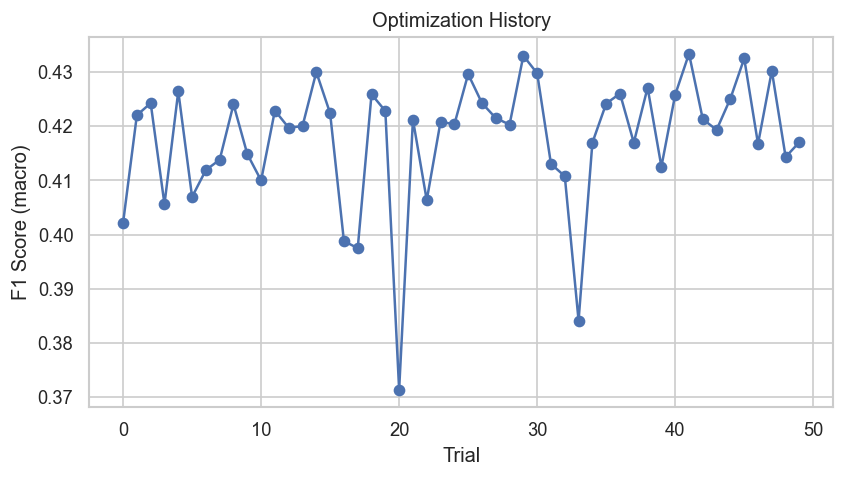

In [52]:
# Visualize optimization history
try:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()
except ImportError:
    print("Showing optimization history as text:")
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best value: {study.best_value:.4f}")
    print(f"Best params: {study.best_params}")
    
    # Alternative: simple matplotlib plot
    import matplotlib.pyplot as plt
    trials = study.trials
    values = [t.value for t in trials if t.value is not None]
    plt.figure(figsize=(8, 4))
    plt.plot(values, marker='o')
    plt.xlabel('Trial')
    plt.ylabel('F1 Score (macro)')
    plt.title('Optimization History')
    plt.grid(True)
    plt.show()


Plotly not available or insufficient variance. Showing parameter information:
  reg_lambda: 0.4121
  gamma: 0.1832
  reg_alpha: 0.1295
  learning_rate: 0.0730
  subsample: 0.0730
  n_estimators: 0.0508
  min_child_weight: 0.0277
  colsample_bytree: 0.0267
  max_depth: 0.0239


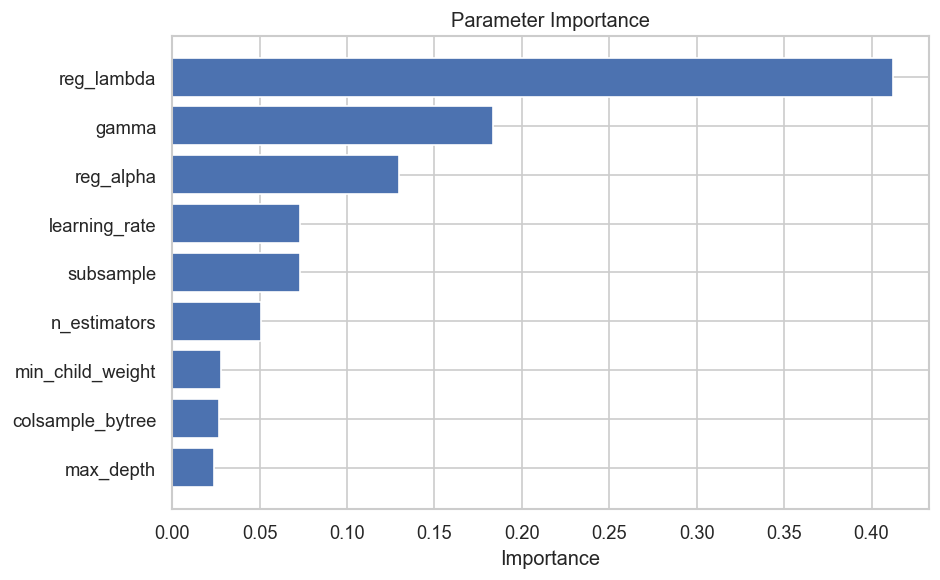

In [53]:
# Visualize parameter importance
try:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()
except (ImportError, RuntimeError) as e:
    print("Plotly not available or insufficient variance. Showing parameter information:")
    try:
        importance = optuna.importance.get_param_importances(study)
        importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)
        for param, imp in importance_sorted:
            print(f"  {param}: {imp:.4f}")
        
        # Alternative: simple matplotlib plot
        import matplotlib.pyplot as plt
        params = [p[0] for p in importance_sorted]
        importances = [p[1] for p in importance_sorted]
        plt.figure(figsize=(8, 5))
        plt.barh(params, importances)
        plt.xlabel('Importance')
        plt.title('Parameter Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    except (ImportError, RuntimeError):
        # Fallback: show best parameters and parameter ranges
        print("Best hyperparameters:")
        for param, value in sorted(study.best_params.items()):
            print(f"  {param}: {value}")
        
        # Show parameter ranges from all trials
        print("\nParameter ranges across all trials:")
        param_ranges = {}
        for trial in study.trials:
            if trial.value is not None:
                for param, value in trial.params.items():
                    if param not in param_ranges:
                        param_ranges[param] = []
                    param_ranges[param].append(value)
        
        for param in sorted(param_ranges.keys()):
            values = param_ranges[param]
            print(f"  {param}: min={min(values):.4f}, max={max(values):.4f}, mean={np.mean(values):.4f}")


## 7) Train final model

- Train XGBoost with best hyperparameters from tuning
- Use all training data


In [54]:
# Get best parameters
best_params = study.best_params.copy()

# Add fixed parameters
best_params.update({
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'booster': 'gbtree',
    'tree_method': 'hist',
    'random_state': RANDOM_STATE,
    'verbosity': 1,
})

# Calculate class weights for final training
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

# Train final model
print("Training final model with best parameters...")
print("Using balanced class weights to handle class imbalance")
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print("Training complete!")


Training final model with best parameters...
Using balanced class weights to handle class imbalance
[0]	validation_0-mlogloss:1.05359
[1]	validation_0-mlogloss:1.03553
[2]	validation_0-mlogloss:1.01152
[3]	validation_0-mlogloss:1.00688
[4]	validation_0-mlogloss:1.00371
[5]	validation_0-mlogloss:0.99682
[6]	validation_0-mlogloss:0.98822
[7]	validation_0-mlogloss:0.98851


[8]	validation_0-mlogloss:0.98792
[9]	validation_0-mlogloss:0.98483
[10]	validation_0-mlogloss:0.98606
[11]	validation_0-mlogloss:0.98815
[12]	validation_0-mlogloss:0.98576
[13]	validation_0-mlogloss:0.98865
[14]	validation_0-mlogloss:0.98902
[15]	validation_0-mlogloss:0.98647
[16]	validation_0-mlogloss:0.98801
[17]	validation_0-mlogloss:0.98695
[18]	validation_0-mlogloss:0.98531
[19]	validation_0-mlogloss:0.98439
[20]	validation_0-mlogloss:0.98416
[21]	validation_0-mlogloss:0.98292
[22]	validation_0-mlogloss:0.98372
[23]	validation_0-mlogloss:0.98704
[24]	validation_0-mlogloss:0.98679
[25]	validation_0-mlogloss:0.98579
[26]	validation_0-mlogloss:0.98561
[27]	validation_0-mlogloss:0.98591
[28]	validation_0-mlogloss:0.98844
[29]	validation_0-mlogloss:0.98776
[30]	validation_0-mlogloss:0.98797
[31]	validation_0-mlogloss:0.98710
[32]	validation_0-mlogloss:0.98488
[33]	validation_0-mlogloss:0.98573
[34]	validation_0-mlogloss:0.98549
[35]	validation_0-mlogloss:0.98667
[36]	validation_0-mlog

## 8) Results

- Evaluate on test set
- Accuracy, macro F1, and log loss metrics
- Confusion matrix visualization


Test Accuracy:  0.5000
Test Macro F1:  0.4946
Test Log Loss:  1.0193

Classification Report:

              precision    recall  f1-score   support

        Loss       0.38      0.49      0.43        55
        Draw       0.60      0.43      0.51       113
         Win       0.50      0.61      0.55        72

    accuracy                           0.50       240
   macro avg       0.50      0.51      0.49       240
weighted avg       0.52      0.50      0.50       240



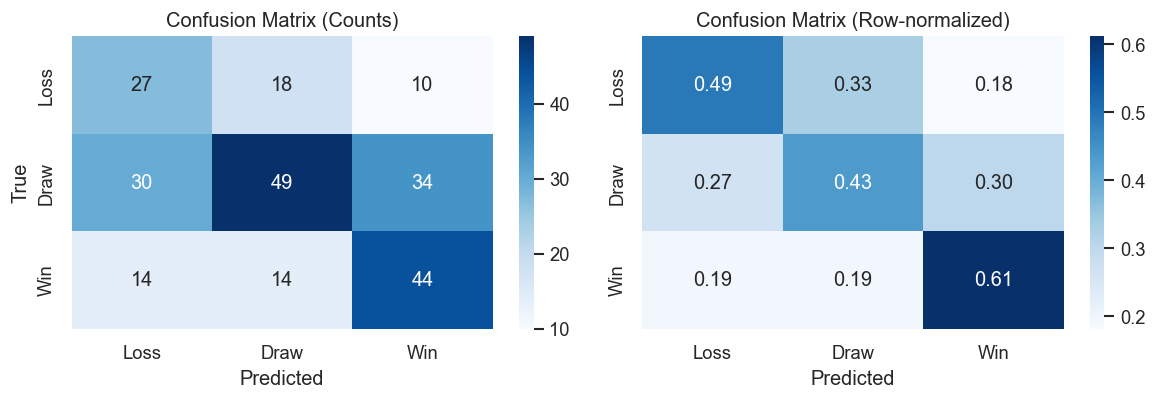

In [55]:
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average="macro")
logloss = log_loss(y_test, y_pred_proba)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Macro F1:  {f1m:.4f}")
print(f"Test Log Loss:  {logloss:.4f}")
print("\nClassification Report:\n")
print(classification_report(
    y_test, y_pred, 
    target_names=[OUTCOME_LABELS[i] for i in [0, 1, 2]]
))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    yticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    ax=axes[0],
)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    yticklabels=[OUTCOME_LABELS[i] for i in [0, 1, 2]],
    ax=axes[1],
)
axes[1].set_title("Confusion Matrix (Row-normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


## 10) Feature importance

- Analyze which features are most important for predictions
- Visualize top contributing features


## 9) Feature importance

- Analyze which features are most important for predictions
- Visualize top contributing features


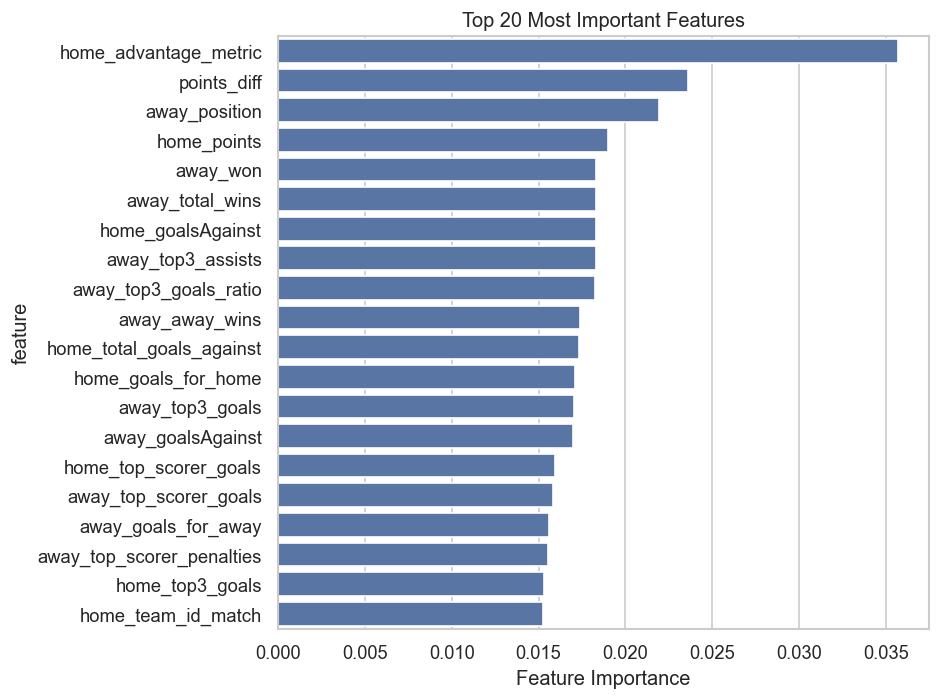


Top 20 features:


,feature,importance
70,home_advantage_metric,0.035672
68,points_diff,0.023608
27,away_position,0.021903
0,home_points,0.018993
21,away_won,0.018327
37,away_total_wins,0.018323
5,home_goalsAgainst,0.018289
60,away_top3_assists,0.018277
65,away_top3_goals_ratio,0.018258
33,away_away_wins,0.017374


In [56]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top features
top_n = 20
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
plt.title(f'Top {top_n} Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} features:")
importance_df.head(top_n)


## 10) Prediction function

- Function to predict match outcomes for new fixtures
- Returns prediction and probability for each outcome


In [57]:
def predict_fixture(
    home_team: str, 
    away_team: str, 
    model: xgb.XGBClassifier = final_model,
    train_df_ref: pd.DataFrame = train_df,
    feature_cols: list = feature_cols,
    imputer: SimpleImputer = imputer
) -> pd.Series:
    """Predict match outcome for a fixture."""
    
    # Find team statistics from training data (or use average if not found)
    home_stats = train_df_ref[train_df_ref["homeTeam_name"] == home_team]
    away_stats = train_df_ref[train_df_ref["awayTeam_name"] == away_team]
    
    if len(home_stats) == 0 or len(away_stats) == 0:
        # Use median values if team not found
        feature_values = train_df_ref[feature_cols].median().values
    else:
        # Use most recent match statistics
        home_row = home_stats.iloc[-1]
        away_row = away_stats.iloc[-1]
        
        # Construct feature vector
        feature_values = []
        for col in feature_cols:
            if col == "homeTeam_encoded":
                feature_values.append(le_home.transform([home_team])[0])
            elif col == "awayTeam_encoded":
                feature_values.append(le_away.transform([away_team])[0])
            elif col.startswith("home_"):
                feature_values.append(home_row.get(col, train_df_ref[col].median()))
            elif col.startswith("away_"):
                feature_values.append(away_row.get(col, train_df_ref[col].median()))
            else:
                # Difference or other features - use median or calculate
                feature_values.append(train_df_ref[col].median())
    
    # Create DataFrame and impute
    X_pred = pd.DataFrame([feature_values], columns=feature_cols)
    X_pred = pd.DataFrame(
        imputer.transform(X_pred),
        columns=feature_cols
    )
    
    # Predict
    probs = model.predict_proba(X_pred)[0]
    pred_class = int(model.predict(X_pred)[0])
    
    out = {
        "homeTeam": home_team,
        "awayTeam": away_team,
        "prediction": OUTCOME_LABELS[pred_class],
        **{f"p_{OUTCOME_LABELS[c]}": float(probs[i]) for i, c in enumerate([0, 1, 2])},
    }
    return pd.Series(out)

# Example predictions
examples = df[["homeTeam_name", "awayTeam_name"]].head(5)

pd.DataFrame(
    [predict_fixture(r.homeTeam_name, r.awayTeam_name) for r in examples.itertuples(index=False)]
)


,homeTeam,awayTeam,prediction,p_Loss,p_Draw,p_Win
0,UD Almería,Rayo Vallecano de Madrid,Loss,0.535452,0.367544,0.097004
1,Sevilla FC,Valencia CF,Draw,0.336308,0.405592,0.258101
2,Real Sociedad de Fútbol,Girona FC,Win,0.229433,0.251105,0.519462
3,UD Las Palmas,RCD Mallorca,Draw,0.165693,0.522831,0.311475
4,Athletic Club,Real Madrid CF,Win,0.271701,0.317877,0.410422


## 11) Model comparison

Compare this XGBoost model with the baseline logistic regression model to see improvements!


In [ ]:
# Model Comparison: XGBoost vs Logistic Regression
# Baseline model results (from multinomial_logreg_match_outcome.ipynb)
baseline_results = {
    "Model": "Logistic Regression",
    "Accuracy": 0.525,
    "Macro F1": 0.513,
    "Log Loss": None,  # Not reported in baseline
    "Loss F1": 0.44,
    "Draw F1": 0.55,
    "Win F1": 0.55,
}

# Current XGBoost model results
xgboost_results = {
    "Model": "XGBoost",
    "Accuracy": acc,
    "Macro F1": f1m,
    "Log Loss": logloss,
    "Loss F1": f1_score(y_test, y_pred, average=None, labels=[0, 1, 2])[0],
    "Draw F1": f1_score(y_test, y_pred, average=None, labels=[0, 1, 2])[1],
    "Win F1": f1_score(y_test, y_pred, average=None, labels=[0, 1, 2])[2],
}

# Create comparison DataFrame
comparison_df = pd.DataFrame([baseline_results, xgboost_results])
comparison_df = comparison_df.set_index("Model")

print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print("\nOverall Metrics:")
print(comparison_df[["Accuracy", "Macro F1", "Log Loss"]].round(4))
print("\nPer-Class F1 Scores:")
print(comparison_df[["Loss F1", "Draw F1", "Win F1"]].round(4))

# Calculate improvements
print("\n" + "=" * 60)
print("IMPROVEMENT ANALYSIS")
print("=" * 60)
acc_improvement = (xgboost_results["Accuracy"] - baseline_results["Accuracy"]) * 100
f1_improvement = (xgboost_results["Macro F1"] - baseline_results["Macro F1"]) * 100

print(f"\nAccuracy: {acc_improvement:+.2f} percentage points")
print(f"Macro F1: {f1_improvement:+.2f} percentage points")

if acc_improvement > 0:
    print(f"\n✓ XGBoost is {acc_improvement:.2f}% more accurate")
elif acc_improvement < 0:
    print(f"\n✗ XGBoost is {abs(acc_improvement):.2f}% less accurate")
else:
    print(f"\n= Both models have similar accuracy")

if f1_improvement > 0:
    print(f"✓ XGBoost has {f1_improvement:.2f}% better macro F1")
elif f1_improvement < 0:
    print(f"✗ XGBoost has {abs(f1_improvement):.2f}% worse macro F1")
else:
    print(f"= Both models have similar macro F1")

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy and F1 comparison
metrics = ["Accuracy", "Macro F1"]
x = np.arange(len(metrics))
width = 0.35

baseline_vals = [baseline_results["Accuracy"], baseline_results["Macro F1"]]
xgboost_vals = [xgboost_results["Accuracy"], xgboost_results["Macro F1"]]

axes[0].bar(x - width/2, baseline_vals, width, label="Logistic Regression", alpha=0.8)
axes[0].bar(x + width/2, xgboost_vals, width, label="XGBoost", alpha=0.8)
axes[0].set_ylabel("Score")
axes[0].set_title("Overall Performance Comparison")
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 0.6])

# Per-class F1 comparison
classes = ["Loss", "Draw", "Win"]
x2 = np.arange(len(classes))
baseline_f1 = [baseline_results["Loss F1"], baseline_results["Draw F1"], baseline_results["Win F1"]]
xgboost_f1 = [xgboost_results["Loss F1"], xgboost_results["Draw F1"], xgboost_results["Win F1"]]

axes[1].bar(x2 - width/2, baseline_f1, width, label="Logistic Regression", alpha=0.8)
axes[1].bar(x2 + width/2, xgboost_f1, width, label="XGBoost", alpha=0.8)
axes[1].set_ylabel("F1 Score")
axes[1].set_title("Per-Class F1 Score Comparison")
axes[1].set_xticks(x2)
axes[1].set_xticklabels(classes)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 0.7])

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Both models show similar performance on this dataset.")
print(f"XGBoost uses {len(feature_cols)} features vs Logistic Regression's team name encoding.")
print(f"XGBoost provides feature importance insights and handles non-linear relationships.")
print(f"Logistic Regression is simpler and faster to train.")
